<a href="https://colab.research.google.com/github/Rjpiit/Image-processing-and-Audio-Reconstruction/blob/master/audio_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [ ]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

--2024-09-16 21:04:46--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.1’

gt_bach.wav.1       100%[===================>]   1.17M  5.99MB/s    in 0.2s    

2024-09-16 21:04:47 (5.99 MB/s) - ‘gt_bach.wav.1’ saved [1232886/1232886]



In [ ]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [ ]:
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')
sr

44100

In [ ]:
audio = audio[0]

In [ ]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.988820861678004 seconds


In [ ]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

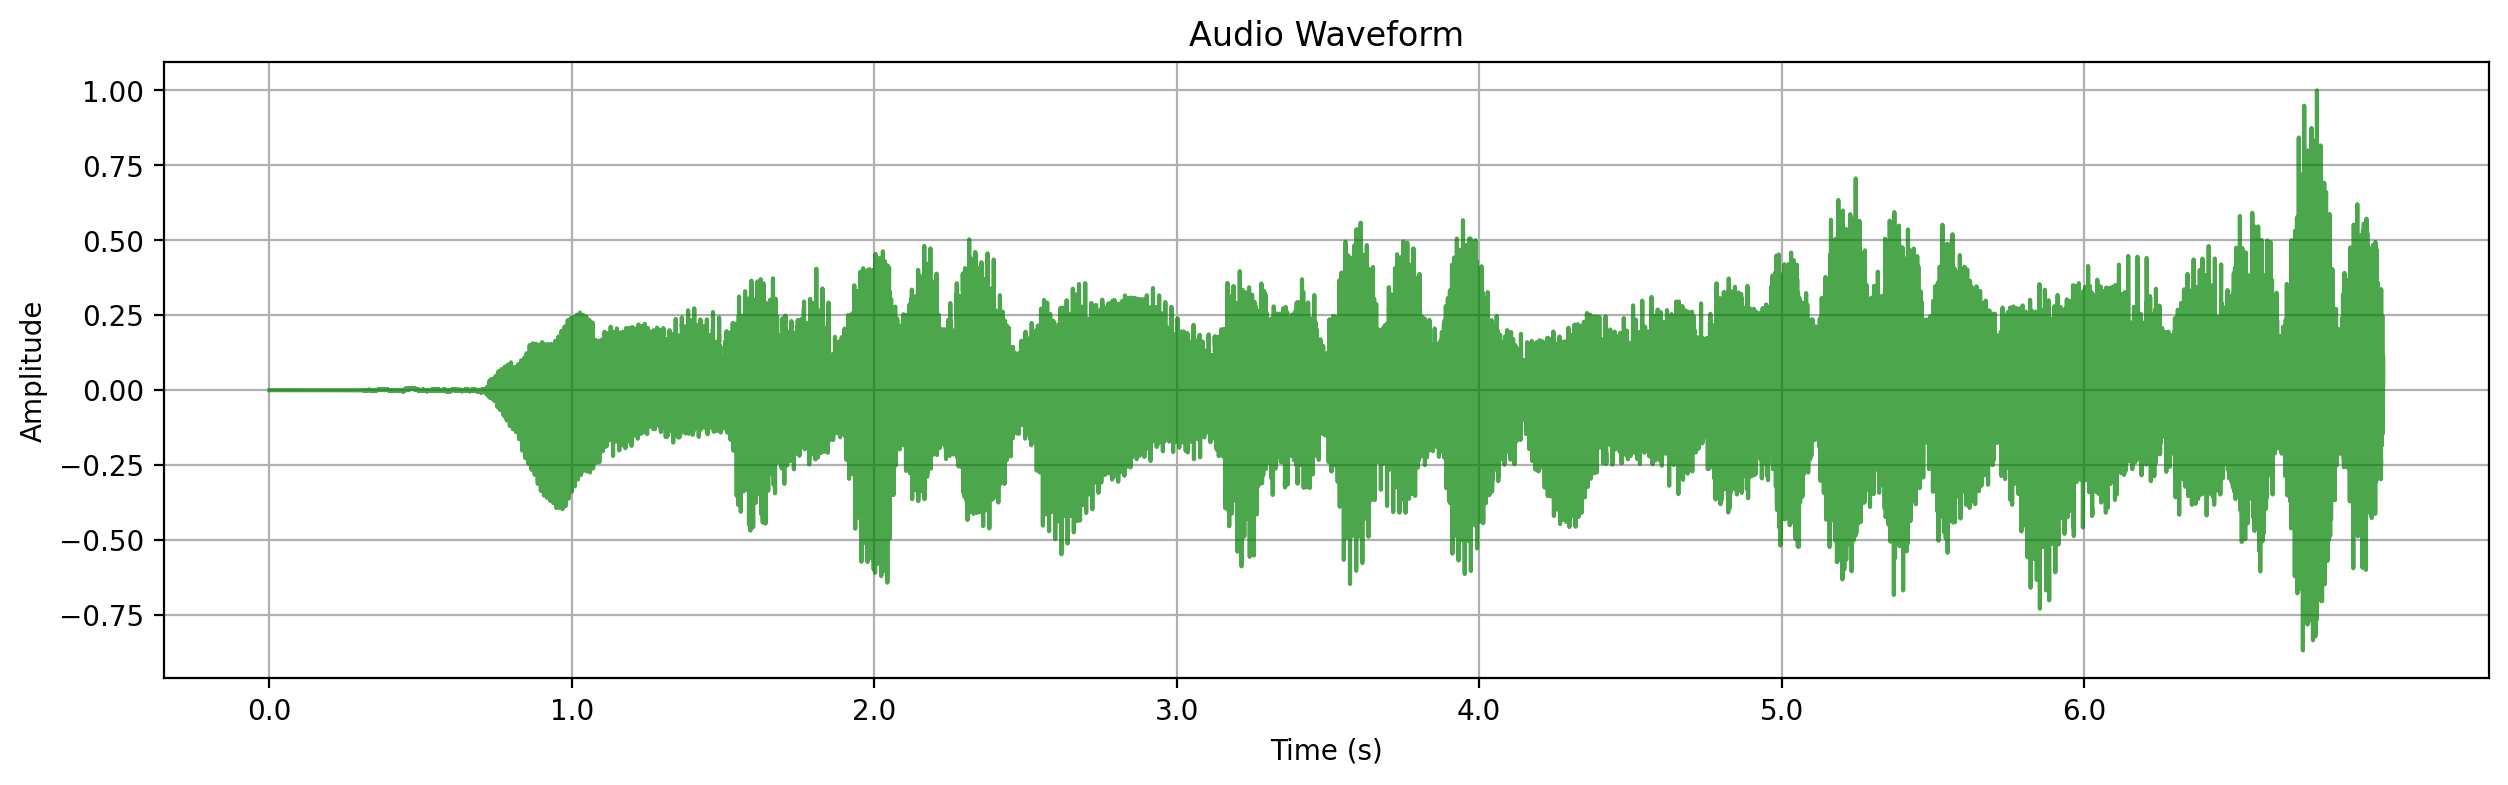

In [ ]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [ ]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([308207, 1])
tensor([[-100.0000],
        [ -99.9994],
        [ -99.9987],
        ...,
        [  99.9987],
        [  99.9994],
        [ 100.0000]])


In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [ ]:
num_features = 3000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([308207, 3000])
tensor([[ 0.0243, -0.0216, -0.0204,  ..., -0.0198, -0.0190,  0.0001],
        [ 0.0238, -0.0224, -0.0204,  ..., -0.0207, -0.0195, -0.0023],
        [ 0.0232, -0.0232, -0.0205,  ..., -0.0216, -0.0199, -0.0047],
        ...,
        [-0.0246, -0.0254, -0.0252,  ...,  0.0134,  0.0157, -0.0123],
        [-0.0241, -0.0250, -0.0252,  ...,  0.0120,  0.0162, -0.0101],
        [-0.0236, -0.0246, -0.0253,  ...,  0.0106,  0.0167, -0.0079]])


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(308207,)


In [ ]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [ ]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(76.75967, 32165.236)

In [ ]:
Audio(pred_audio, rate = sr)

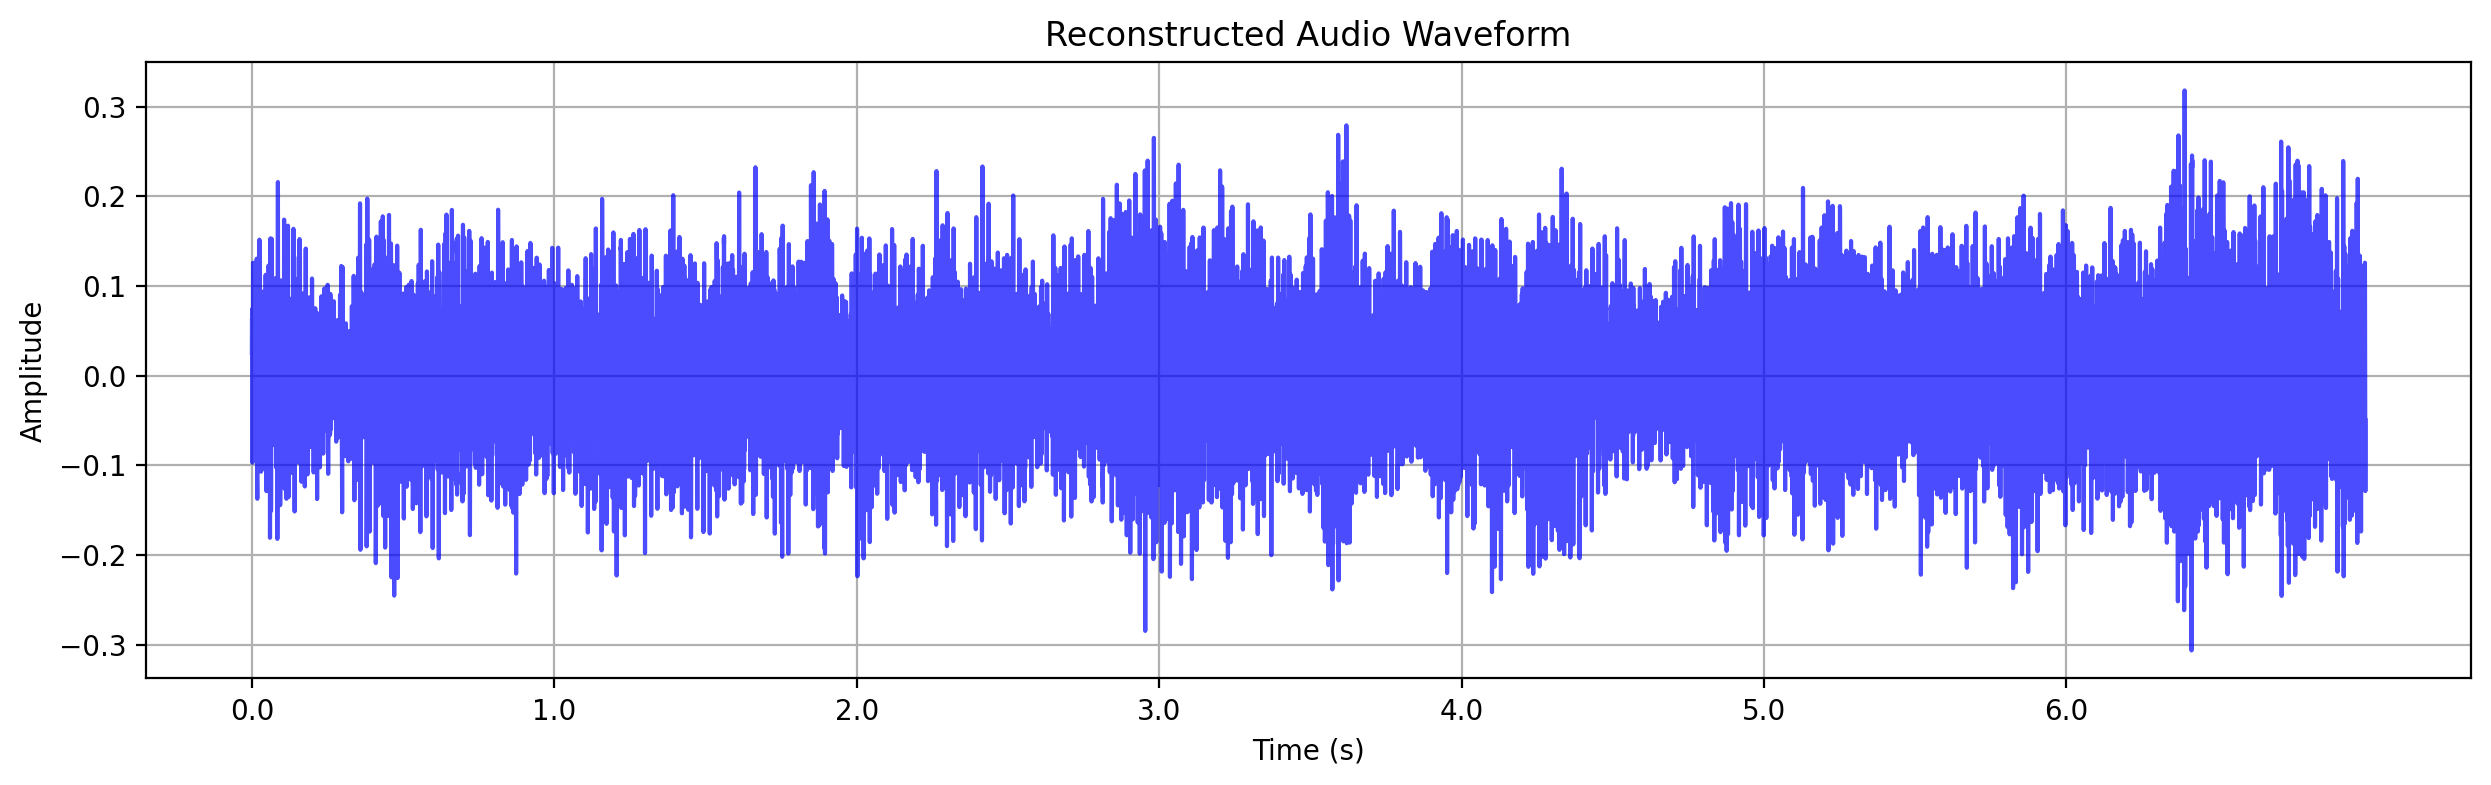

In [ ]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

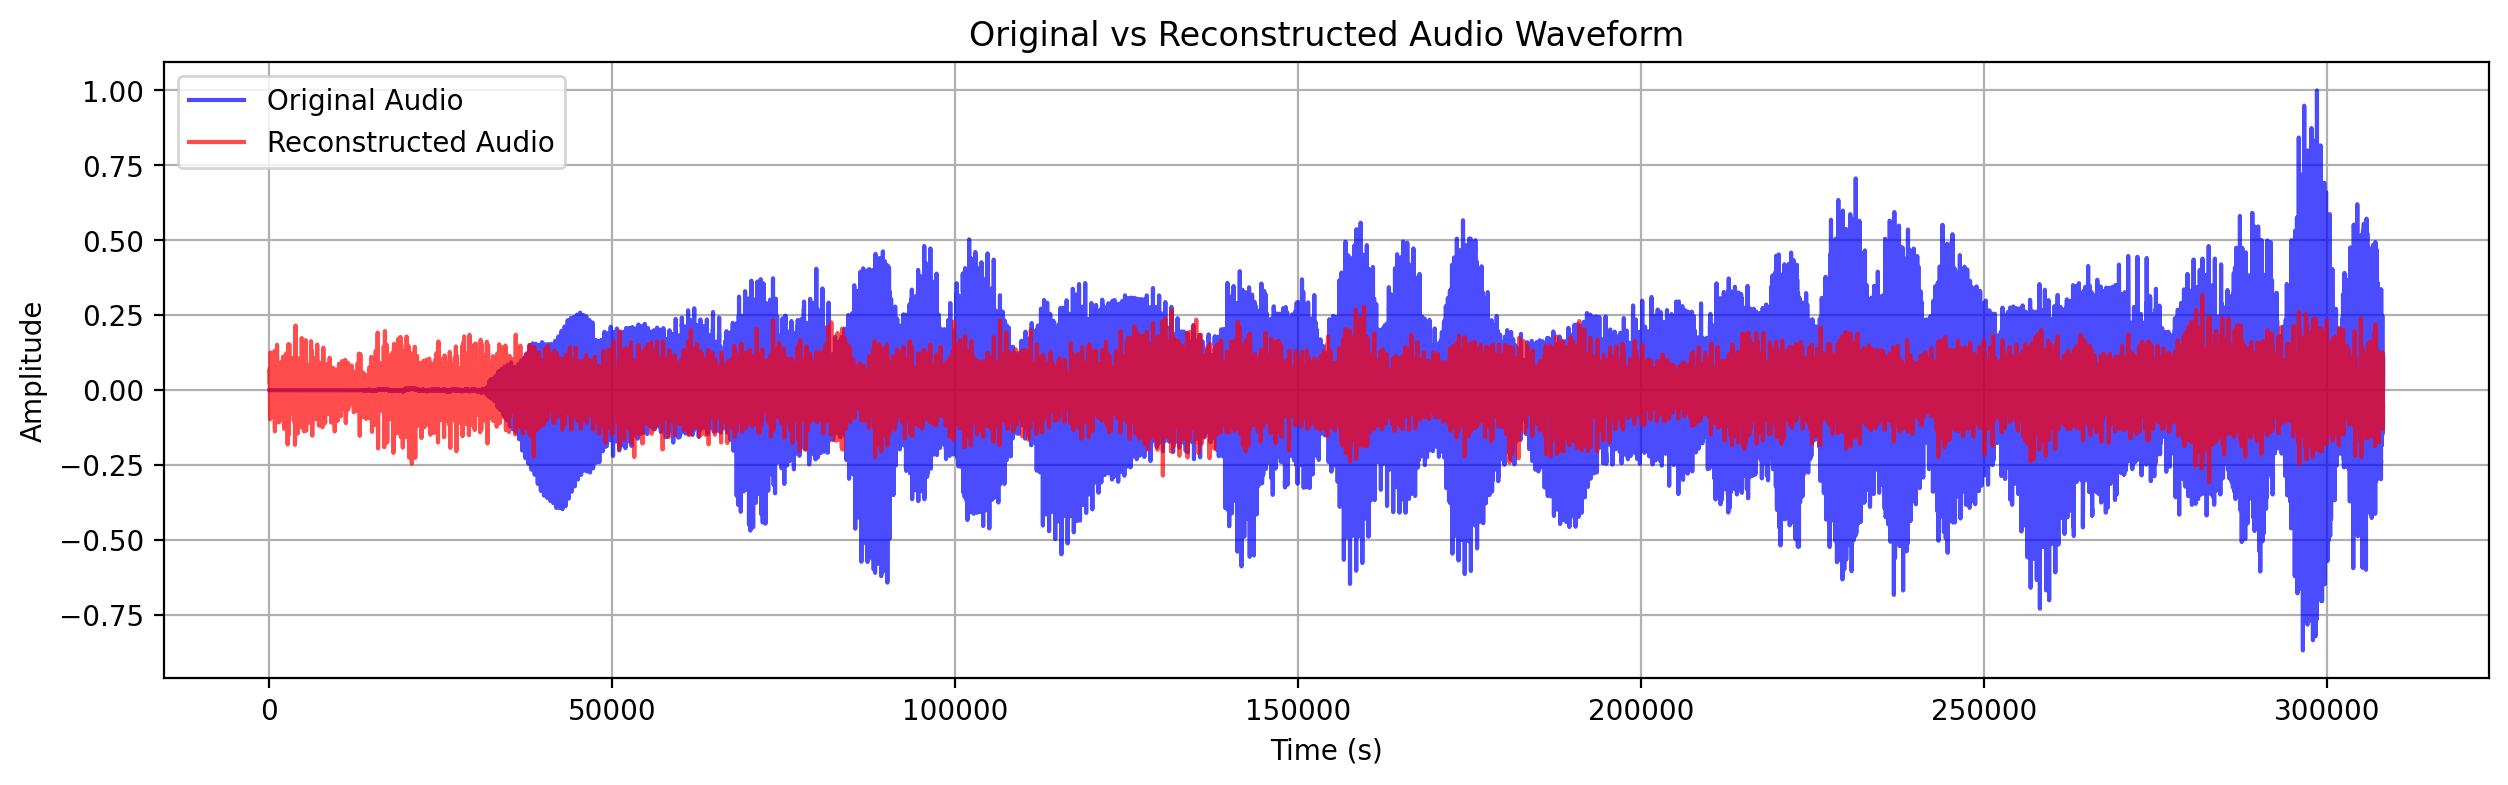

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_reconstruction(original_signal, reconstructed_signal):
    # If original_signal and reconstructed_signal are PyTorch tensors, convert them to NumPy arrays
    if isinstance(original_signal, torch.Tensor):
        original_signal = original_signal.detach().cpu().numpy()
    if isinstance(reconstructed_signal, torch.Tensor):
        reconstructed_signal = reconstructed_signal.detach().cpu().numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(original_signal, reconstructed_signal))

    # Calculate SNR (Signal to Noise Ratio)
    signal_power = np.mean(original_signal**2)
    noise_power = np.mean((original_signal - reconstructed_signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)

    return rmse, snr

# Example usage:
rmse, snr = evaluate_reconstruction(audio, pred_audio)

# Print evaluation results
print(f"RMSE: {rmse}")
print(f"SNR: {snr} dB")


RMSE: 0.13826490938663483
SNR: 1.024528592824936 dB
